<a href="https://colab.research.google.com/github/cnddlf/Deep-Learning-Study/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from typing import Any, Callable, List, Optional, Tuple
from easydict import EasyDict

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Model
DenseNet-121

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleNeck, self).__init__()
        inner_channels = 4 * growth_rate

        self.residual = nn.Sequential(
            # BN - ReLU - 1x1 - BN - ReLU - 3x3
            # 1x1 conv = make before feature-map to 4k, if layers go deep, it become big, so downsize
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, inner_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
            # 3x3 conv
            nn.BatchNorm2d(inner_channels),
            nn.ReLU(),
            nn.Conv2d(inner_channels, growth_rate, kernel_size = 3, stride = 1, padding = "same", bias = False)
        )

        self.shortcut = nn.Sequential()

    def forward(self, x):
        return torch.cat([self.shortcut(x), self.residual(x)], dim=1)

In [ ]:
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.BN(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avgpool(x)
        return x

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, nblocks, growth_rate=12, reduction=0.5, num_classes=10, init_weight = True):
        super(DenseNet, self).__init__()

        self.growth_rate = growth_rate
        # initial convolution layer comprises 2k convolutions - paper
        inner_channels = 2 * growth_rate

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, inner_channels, kernel_size = 7, stride= 2, padding = 3),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )

        # now channels = 2k

        # Dense Block 1
        layers = []
        for i in range(nblocks[0]):
            layers.append(BottleNeck(inner_channels, self.growth_rate))
            # every time concatenate, +k
            inner_channels += self.growth_rate
        self.dense1 = nn.Sequential(*layers)

        # Transition 1
        out_channels = int(reduction * inner_channels)
        self.trans1 = Transition(inner_channels, out_channels)

        inner_channels = out_channels

        # Dense Blcock 2
        layers = []
        for i in range(nblocks[1]):
            layers.append(BottleNeck(inner_channels, self.growth_rate))
            # every time concatenate, +k
            inner_channels += self.growth_rate
        self.dense2 = nn.Sequential(*layers)

        # Transition 2
        out_channels = int(reduction * inner_channels)
        self.trans2 = Transition(inner_channels, out_channels)

        inner_channels = out_channels

        # Dense Blcock 3
        layers = []
        for i in range(nblocks[2]):
            layers.append(BottleNeck(inner_channels, self.growth_rate))
            # every time concatenate, +k
            inner_channels += self.growth_rate
        self.dense3 = nn.Sequential(*layers)

        # Transition 3
        out_channels = int(reduction * inner_channels)
        self.trans3 = Transition(inner_channels, out_channels)

        inner_channels = out_channels

        # Dense Blcock 4
        layers = []
        for i in range(nblocks[3]):
            layers.append(BottleNeck(inner_channels, self.growth_rate))
            # every time concatenate, +k
            inner_channels += self.growth_rate
        self.dense4 = nn.Sequential(*layers)

        # Classifier
        self.bn = nn.BatchNorm2d(inner_channels)
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(inner_channels, num_classes)

        if init_weight:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.dense1(x)
        x = self.trans1(x)
        x = self.dense2(x)
        x = self.trans2(x)
        x = self.dense3(x)
        x = self.trans3(x)
        x = self.dense4(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = nn.Flatten()(x)
        x = self.linear(x)
        return x

    # initialize weights
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    # if bias exist, bias = 0
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
def DenseNet_121():
  return DenseNet([6, 12, 24, 6])

In [ ]:
x = torch.randn(3, 3, 224, 224)
model = DenseNet_121()
output = model(x)
print(output.size)

<built-in method size of Tensor object at 0x795d50e5ce00>


In [ ]:
# print model summary
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]           3,552
         MaxPool2d-2           [-1, 24, 55, 55]               0
       BatchNorm2d-3           [-1, 24, 55, 55]              48
              ReLU-4           [-1, 24, 55, 55]               0
            Conv2d-5           [-1, 48, 55, 55]           1,152
       BatchNorm2d-6           [-1, 48, 55, 55]              96
              ReLU-7           [-1, 48, 55, 55]               0
            Conv2d-8           [-1, 12, 55, 55]           5,184
        BottleNeck-9           [-1, 36, 55, 55]               0
      BatchNorm2d-10           [-1, 36, 55, 55]              72
             ReLU-11           [-1, 36, 55, 55]               0
           Conv2d-12           [-1, 48, 55, 55]           1,728
      BatchNorm2d-13           [-1, 48, 55, 55]              96
             ReLU-14           [-1, 48,

#Train
Train model by CIFAR-10

In [ ]:
def load_dataset():
    # preprocess
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Resize((224, 224))
    ])

    # load data
    train = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    test = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train, batch_size=args.batch_size, shuffle = True)
    test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)
    return train_loader, test_loader

In [ ]:
args = EasyDict()
args.batch_size = 64
args.learning_rate = 0.1
args.n_epochs = 10

# functions
criterion = nn.CrossEntropyLoss(reduction = 'sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

PATH = '/content/gdrive/MyDrive/Colab Notebooks/DenseNet121.pt'
import os.path

epoch_start = 1

if os.path.exists(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch'] + 1
    print("successfully loaded!")
    print("epoch saved until here: ", epoch_start-1)
    print("train starts from this epoch: Epoch ", epoch_start)

In [ ]:
import time

# load dataset
train_loader, test_loader = load_dataset()

loss_hist = []
accuracy_hist = []

start_time = time.time()

# train
for epoch in range(epoch_start, args.n_epochs+1):
    model.train()
    train_loss = 0
    correct, count = 0, 0
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(output, 1) # torch max output is (max, max_index)
        count += labels.size(0)
        correct += torch.sum(preds == labels)

    loss_hist.append(train_loss/count)
    accuracy_hist.append(correct/count)
    print(f"[*] Epoch: {epoch} \tTrain accuracy: {correct/count} \tTrain Loss: {train_loss/count}")
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        }, PATH)

end_time = time.time()

print(f"Training time : {end_time - start_time}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[*] Epoch: 1 	Train accuracy: 0.16142000257968903 	Train Loss: 2.182227864379883
[*] Epoch: 2 	Train accuracy: 0.3081800043582916 	Train Loss: 1.7206661599731445
[*] Epoch: 3 	Train accuracy: 0.4515399932861328 	Train Loss: 1.442236643295288
[*] Epoch: 4 	Train accuracy: 0.5301600098609924 	Train Loss: 1.2779244638633729
[*] Epoch: 5 	Train accuracy: 0.5771399736404419 	Train Loss: 1.1581761033630371
[*] Epoch: 6 	Train accuracy: 0.615559995174408 	Train Loss: 1.064833627357483
[*] Epoch: 7 	Train accuracy: 0.646079957485199 	Train Loss: 0.9861134046936035
[*] Epoch: 8 	Train accuracy: 0.6681999564170837 	Train Loss: 0.9250734036445618
[*] Epoch: 9 	Train accuracy: 0.6857999563217163 	Train Loss: 0.8739162010955811
[*] Epoch: 10 	Train accuracy: 0.703499972820282 	Train Loss: 0.8315296445655823
Training time : 3031.937823534012


In [ ]:
# test
model.eval()
correct, count = 0, 0
test_loss = 0

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()
        _, preds = torch.max(output, 1)
        count += labels.size(0)
        correct += torch.sum(preds == labels)

print(f"Test accuracy: {correct/count} \tTest Loss: {test_loss/count}")

Test accuracy: 0.7098999619483948 	Test Loss: 0.8409873401641845


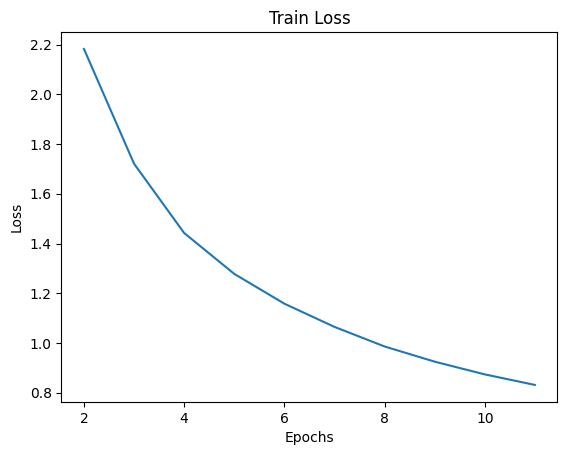

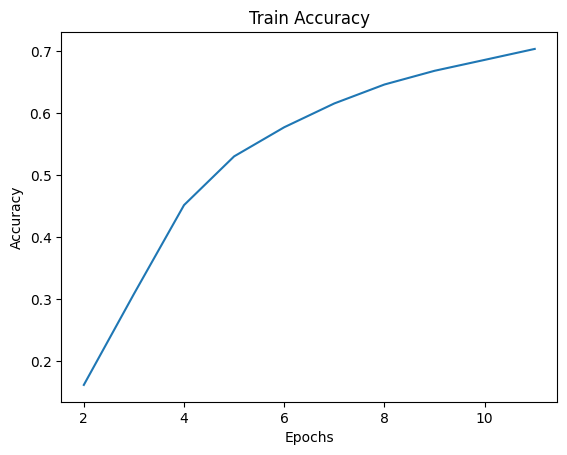

In [ ]:
# plot graph
width = len(loss_hist)
plt.title("Train Loss")
plt.plot(range(epoch_start+1, width+epoch_start+1), loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

accuracy_hist2 = torch.stack(accuracy_hist).cpu().tolist()
plt.title("Train Accuracy")
plt.plot(range(epoch_start+1, width+epoch_start+1), accuracy_hist2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()